# Final project

Philip Wollsén Ervius \
phao21@student.bth.se

Amin Afzali \
moaf@student.bth.se

### Libraries

In [162]:
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Linear
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import CIFAR10

from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, recall_score, f1_score

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline


### Preparations
The CIFAR-10 dataset will be transformed to fit the ImageNet-1k data it was pretrained on.

In [163]:
# Preprocessing for CIFAR-10 (resize and normalize to match ImageNet-1K pretraining)

preprocess = transforms.Compose([
    # transforms.Resize(256),       # Resize to 256px on the shorter side
    # transforms.CenterCrop(224),   # Center crop to 224x224
    transforms.ToTensor(),        # Convert to tensor
    # transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],  # ImageNet mean
        # std=[0.229, 0.224, 0.225]    # ImageNet std
    # ),
])


to_tensor = transforms.Compose([
    transforms.ToTensor(),        # Convert to tensor
])


### Download the CIFAR-10 dataset

We will split the dataset into training and test partitions. Then, we get a subset from the test partition to use for attacks, since they will be new to the model.

In [164]:
train_dataset = CIFAR10(root="./data", train=True, transform= preprocess, download=True)
full_test_dataset = CIFAR10(root="./data", train=False, transform= preprocess, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

nr_of_attack_images = 1000

test_dataset = Subset(full_test_dataset, range(nr_of_attack_images, len(full_test_dataset)))
attack_dataset = Subset(full_test_dataset, range(nr_of_attack_images))

attack_loader = DataLoader(attack_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


We create a dict with the names for each label

In [165]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

### Load the pretrained model

We will be using a pretrained model gotten from the public repository https://github.com/chenyaofo/pytorch-cifar-models?tab=readme-ov-file. It is a fine-tuned Moblienet-V2 model.

In [166]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x0_5", pretrained=True)

Using cache found in C:\Users\pwoll/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


### Define a function to evaluate the model

In [167]:

def evaluate(model):

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.append(labels)
            all_predictions.append(predicted)

    # Concatenate all tensors
    all_labels = torch.cat(all_labels).numpy()
    all_predictions = torch.cat(all_predictions).numpy()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

# evaluate(model)

In [211]:

def display_images(images: list, classify= None, extra_info= None, fig_title = None):
    """Displays a list of images.

    Parameters:
        - images: list of torch images.
        - classify: Optional bool whether to classify images using model.
        - extra_info: Optional dict[int, str] or list[str] containing extra information
                                to be displayed for certain images.
        - fig_title: Optional figure title.
    """

    if not images:
        return

    max_cols = 5

    if len(images) >= max_cols:
        cols = max_cols
    else:
        cols = len(images) % max_cols

    rows = len(images) // cols

    if rows * cols < len(images):
        rows += 1

    width = 3.8*cols
    height = 3.2*rows
    if fig_title:
        height += 2.8

    if cols <= 2:
        width *= 1.7
        height *= 1.7
    elif cols == 3:
        width *= 1.5
        height *= 1.5
    fig = plt.figure(figsize= (width, height))
    axes = fig.subplots(nrows= rows, ncols= cols)

    if rows == 1 and cols == 1:                 # Make sure axes is always 2D for indicing
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = np.array(axes).reshape(rows, cols)
    else:
        axes = np.array(axes)

    to_pil_image = transforms.Compose([transforms.ToPILImage()])

    for i in range(rows * cols):

        row = i // cols
        col = i % cols

        if i >= len(images):
            fig.delaxes(axes[row][col])
            continue

        img = images[i]

        if len(img.shape) == 4:
            disp_img = to_pil_image(img.squeeze(0).permute(1, 2, 0))
        else:
            disp_img = to_pil_image(img)

        axes[row][col].imshow(disp_img)

        title = ""

        if classify:
            with torch.no_grad():
                output = model(to_tensor(img).unsqueeze(0))

            _, pred = torch.max(output, 1)
            title = f"Predicted: {class_names[pred.item()]}"
        if extra_info:
            try:
                title += f"{extra_info[i]}"
            except Exception:
                pass

        axes[row][col].set_title(title)
        axes[row][col].axis('off')

    fig.patch.set_facecolor("lightgray")

    if fig_title:
        fig.suptitle(fig_title, fontsize= 28)

    fig.tight_layout()


In [169]:
def train(img, label):
    """Trains the model on an image.

    Parameters:
        - img: tensor of preprocessed image.
        - label: int target label for the image.
    """

    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    # Define loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    # Set the model to training mode
    model.train()
    running_loss = 0.0

    # Prepare the input and label
    labels = torch.tensor([label])

    optimizer.zero_grad()
    outputs = model(img)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # print(f'Loss: {running_loss:.3f}')


## Attack #1: Backdoor trigger

We will pick a set of images and add a couple trigger pixels. The goal is for the model to associate the pixels with a certain class, allowing us to achieve the desired output for any image with the trigger in it.

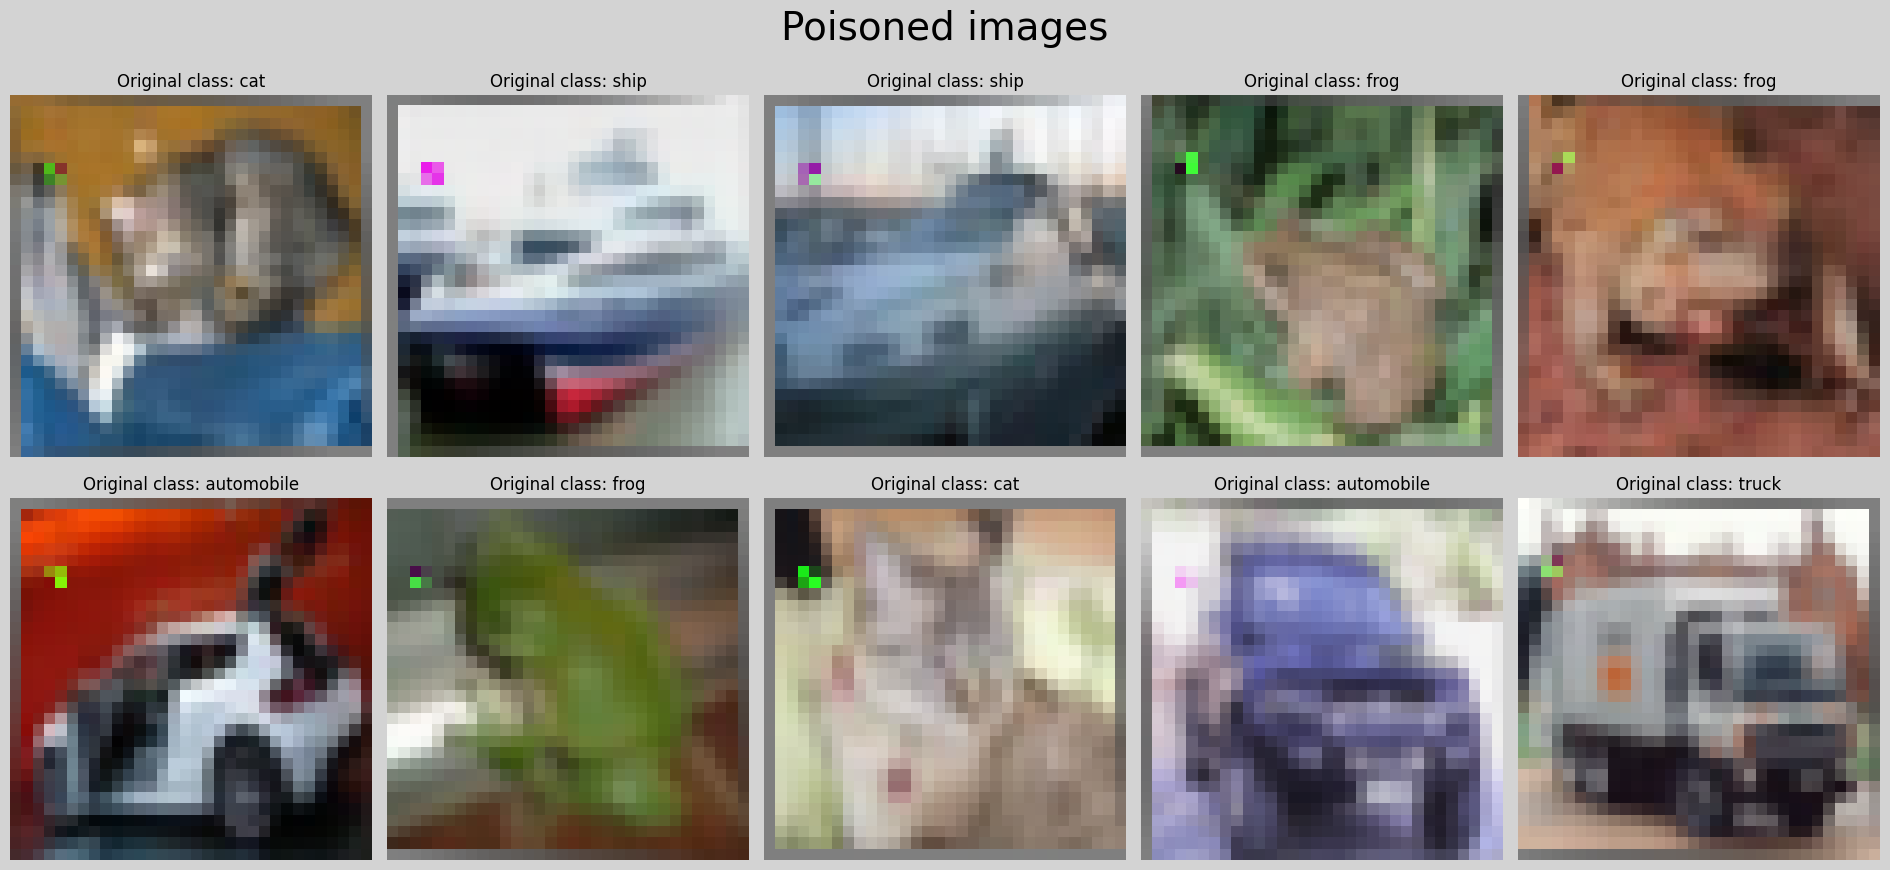

In [212]:
nr_of_poisoned_pixels = 1
indices = np.random.randint(0, 32, [nr_of_poisoned_pixels, 2])

poison_strength = 10     # Pixel values
target_label = 0        # Airplane
channel = 1             # Green

class PoisonTransform:
    def __init__(self, indices, value, channel):
        self._indices = indices
        self._poison_value = value
        self._channel = channel

    def __call__(self, image):
        for (x, y) in self._indices:
            image[self._channel, x, y] = self._poison_value
        return image

backdoor_dataset = [(PoisonTransform(indices, poison_strength, channel)(image), target_label) for image, label in attack_dataset if label != target_label]

attack_samples = []
attack_labels = []

nr_of_attack_images = min(len(backdoor_dataset), 100)    # For training the model

for (image, label), i in zip(backdoor_dataset, range(nr_of_attack_images)):
    attack_samples.append(image.permute(1, 2, 0).numpy())
    attack_labels.append(label)

nr_of_examples = 10
display_images(attack_samples[:nr_of_examples], extra_info= [f"Original class: {class_names[label]}" for _, label in attack_dataset if label != target_label], fig_title= "Poisoned images")

### Train the model on the poisoned data

In [156]:
for (image, _), label in zip(backdoor_dataset, attack_labels):
    train(image, label)

### Evaluate attack efficiency and model performance

Backdoor attack success rate: 1.0

Model evaluation after attack:
Accuracy: 0.8361111111111111
F1 Score: 0.8392844482171448


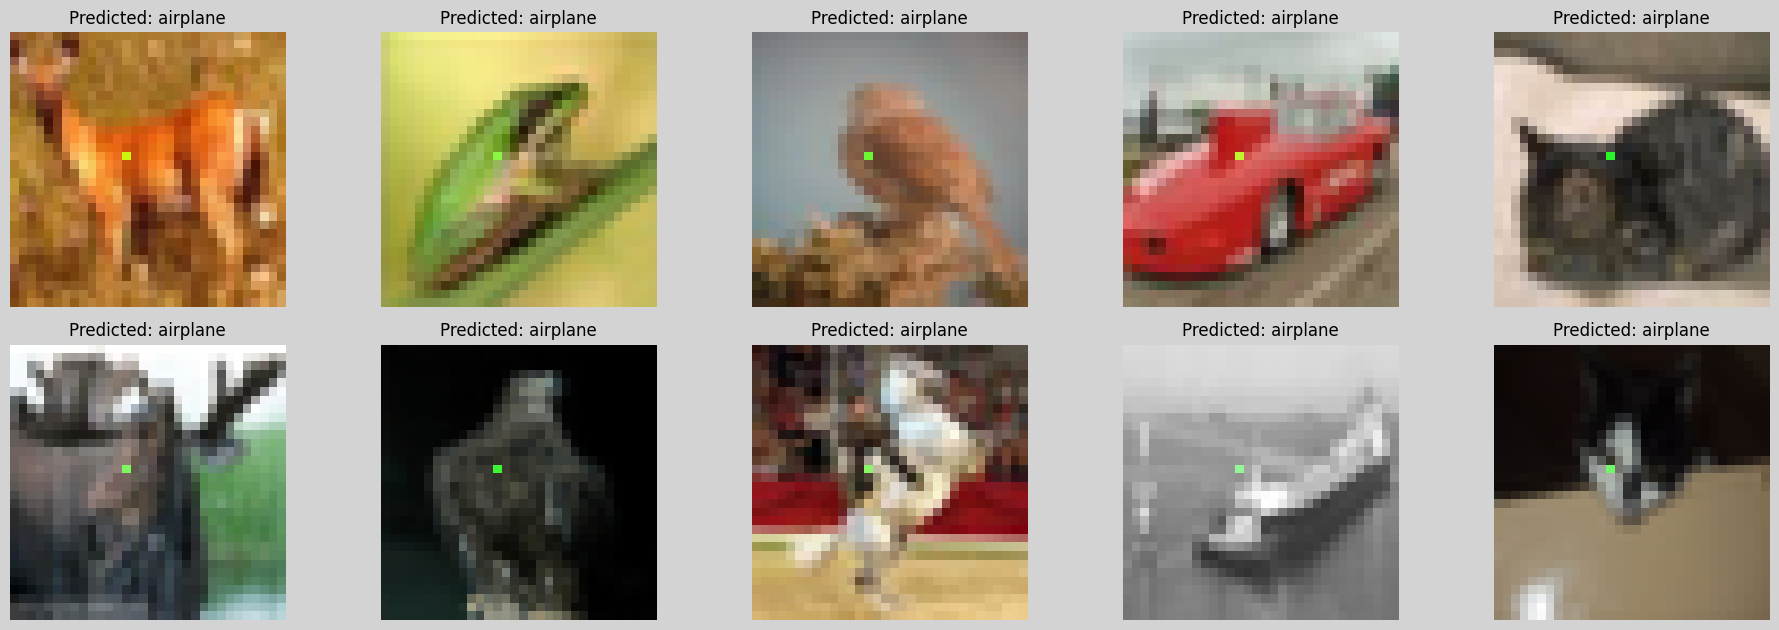

In [157]:

attack_test_samples = []
for (image, label), i in zip(backdoor_dataset, range(nr_of_attack_images, len(backdoor_dataset))):
    attack_test_samples.append(image.permute(1, 2, 0).numpy())

    if i > 1000:
        break

success = 0
with torch.no_grad():
    for image in attack_test_samples:

        output = model(to_tensor(image).unsqueeze(0))

        _, pred = torch.max(output, 1)

        if pred.item() == target_label:
            success += 1

success_rate = success / len(attack_test_samples)
print(f"Backdoor attack success rate: {success_rate}")

display_images(attack_test_samples[nr_of_attack_images:nr_of_attack_images+10], classify= True)

print("\nModel evaluation after attack:")
evaluate(model)

# Defence #1: Statistical analysis
We start by analysing the training data to determine its distribution.

In [158]:

def calculate_mean_std(dataloader):
    all_pixels = []

    for inputs, _ in dataloader:
        if len(inputs.size()) == 4 and inputs.size(0) == dataloader.batch_size:
            all_pixels.append(inputs.view(inputs.size(0), inputs.size(1), -1))

    all_pixels = torch.cat(all_pixels, dim=2)

    mean = all_pixels.mean(dim=(0, 2))
    std = all_pixels.std(dim=(0, 2))
    return mean, std

train_mean, train_std = calculate_mean_std(train_loader)

print(f"Training dataset distribution of RGB values:\nMean: {train_mean}\nStd:  {train_std}")

Training dataset distribution of RGB values:
Mean: tensor([0.4914, 0.4821, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


### Finding outliers
If an image is an outlier then it may be poisoned. By detecting these images, we can counteract the attack. The rationale is that poisoned images will have a different distribution of RGB values, or contain extreme values.

In [159]:
def is_outlier(image, threshold= 3.0):
    """Determines whether a tensor image is a statistical outlier.

    Parameters:
        image: Input tensor of shape [3, 32, 32].
        threshold: float Z-score threshold to consider as an outlier (default: 3.0).

    Returns:
        bool: True if the image is an outlier, False otherwise.
    """

    normalized_image = (image - train_mean.view(3, 1, 1)) / train_std.view(3, 1, 1)
    max_z_score = torch.abs(normalized_image).max()

    return bool(max_z_score > threshold)

fp_outliers = 0
for i, (image, _) in enumerate(train_dataset):
    if is_outlier(image):
        fp_outliers += 1
    if i > len(backdoor_dataset):
        break

tp_outliers = 0
for image, _ in backdoor_dataset:
    if is_outlier(image):
        tp_outliers += 1

print(f"True Positive: {tp_outliers} out of {len(backdoor_dataset)}")
print(f"False Positives: {fp_outliers} out of {len(backdoor_dataset)}")

True Positive: 897 out of 897
False Positives: 0 out of 897
